In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions_configs import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

import PyMieScatt as pms
from analyzing_functions import *

seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Load models

In [2]:
model_name_iv = 'forward_model/surrogate_model'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_iv1_small/models'

model_name_fw = 'forward_model/surrogate_model'
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1_small/models'
plot_dir= '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1_small/plots_meas_original'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [3]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

In [4]:
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)


# Load data

In [5]:
# measurement data  - need to be divided by (4*np.pi)
meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'
dvar_meas = pd.read_hdf(meas_datafile,'dvar')
#meas_datafile = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221219.h5'
#dvar_meas = pd.read_hdf(meas_datafile,'param')

qoi_meas = pd.read_hdf(meas_datafile,'qoi')

qoi_meas



F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      10.292988     10.202447     10.157936     10.068842      9.942028   
1     319.713326    311.680040    305.246269    301.256849    291.003992   
2     171.628669    169.025406    158.073357    153.320459    158.689681   
3     255.490087    263.406212    248.650204    191.072936    193.379311   
4     169.661308    155.736160    131.068012    120.460237    113.132208   
5      11.623200     11.522790     11.485159     11.458338     11.334892   
6      31.195179     30.793104     30.730566     30.576065     30.276192   
7      69.230554     68.843726     68.329483     68.201156     67.597278   
8     150.179422    149.474910    147.978382    146.385494    144.246849   
9     123.497759    122.980150    121.288541    121.158893    119.360380   
10    241.011311    237.770535    234.895710    232.139757    228.766429   
11    188.023911    182.209560    177.159020    172.017967    166.335981   
12    356.248809    348.305503    337.111139    324.849469    316.144836   
13     97.698322     91.911165    114.354964    112.676577    101.879081   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       9.933527      9.899784      9.816825      9.784930      9.716613  ...   
1     278.475044    274.752536    273.223423    267.624397    256.391614  ...   
2     157.512209    147.067530    133.207793    114.915648    109.312189  ...   
3     192.970691    157.444078    131.005377    101.921150     72.523689  ...   
4      93.974540     71.949823     57.866504     49.493270     41.002167  ...   
5      11.293051     11.320542     11.206947     11.150377     11.141497  ...   
6      29.963659     29.745276     29.570581     29.269259     28.896808  ...   
7      66.456888     65.266585     64.066910     63.034934     62.091119  ...   
8     141.770377    139.398776    136.896733    135.392823    133.886400  ...   
9     116.715543    114.625422    112.745620    110.197502    107.388154  ...   
10    221.139446    213.688628    209.061573    206.097833    200.159731  ...   
11    162.174808    158.447923    153.780910    146.588038    139.157964  ...   
12    299.782826    292.176839    284.467388    260.428515    240.398889  ...   
13     95.227836     94.071005     90.683122     81.403601     67.999321  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.062705       0.058236       0.053258       0.041816       0.041821   
1       -0.442089      -0.402139      -0.369479      -0.335306      -0.310288   
2       -0.739106      -0.691336      -0.679427      -0.630740      -0.600472   
3       -0.575264      -0.536323      -0.507552      -0.553375      -0.525443   
4       -0.522459      -0.503661      -0.471962      -0.416038      -0.316883   
5        0.081435       0.078506       0.070624       0.065684       0.061138   
6        0.143271       0.121091       0.095935       0.084857       0.076034   
7       -0.085548      -0.104193      -0.112898      -0.077543      -0.072952   
8        0.021192       0.023545       0.023041       0.017631       0.031869   
9        0.239359       0.201787       0.167051       0.162393       0.164037   
10      -0.092794      -0.076136      -0.073104      -0.087072      -0.075848   
11       0.006520       0.018406       0.006810      -0.032775      -0.008622   
12       0.129906       0.116541       0.098241       0.084517       0.102488   
13       0.047823      -0.017431      -0.018607       0.080858      -0.055929   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.047582       0.038348       0.036427       0.037912       0.040365  
1       -0.296504      -0.274272      -0.237057      -0.190713      -0.155765  
2       -0.533391      -0.463790      -0.395754      -0.312426      -0.241548  
3       -0.337376      -0.288274      -0.286020      -0.250328      -0.227706  
4       -0.171938      -0.12752

In [6]:
# Pymiescatt simulation of dvar_meas - truncated angles need to be removed
qoi_meas_pymiescatt = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
qoi_meas_pymiescatt

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [7]:
# Processed version of qoi_meas - need to be divided by (4*np.pi)
qoi_meas_preprocessed = pd.read_csv('/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_qoi.txt')

qoi_meas_preprocessed = qoi_meas_preprocessed.drop(['Unnamed: 0'], axis = 1)
qoi_meas_preprocessed


#meas_datafile_preprocessed = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_december2022/uneph_data_20221220.h5'
#dvar_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'param')

#qoi_meas_preprocessed = pd.read_hdf(meas_datafile_preprocessed,'qoi')
#qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      10.296788     10.205574     10.161950     10.073487      9.943219   
1     319.779352    311.747859    305.310004    301.307994    291.052387   
2     171.675870    169.061589    158.103149    153.350741    158.728432   
3     255.561578    263.482330    248.702459    191.112573    193.423337   
4     169.706184    155.755448    131.101031    120.469612    113.130104   
5      11.624838     11.523947     11.487458     11.461293     11.335395   
6      31.200539     30.792264     30.732224     30.580233     30.276894   
7      69.233568     68.842020     68.327381     68.199014     67.595073   
8     150.211461    149.495152    147.999755    146.407612    144.265127   
9     123.526875    122.993685    121.299332    121.170892    119.371122   
10    241.075302    237.814939    234.940610    232.185053    228.807393   
11    188.077467    182.244118    177.189778    172.045359    166.358831   
12    356.289523    348.342938    337.152942    324.906405    316.194737   
13     97.748704     91.944864    114.392993    112.689452    101.890084   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0       9.932848      9.898133      9.812126      9.780692      9.713143  ...   
1     278.527277    274.810342    273.276961    267.670406    256.429970  ...   
2     157.553536    147.105122    133.240790    114.931483    109.322211  ...   
3     193.023367    157.498141    131.035870    101.940804     72.543582  ...   
4      93.978311     71.961964     57.870742     49.497148     41.000065  ...   
5      11.292185     11.318596     11.203328     11.143059     11.132492  ...   
6      29.964346     29.746688     29.569510     29.268835     28.897714  ...   
7      66.455947     65.265902     64.064075     63.030589     62.087433  ...   
8     141.788059    139.418343    136.915128    135.413765    133.908431  ...   
9     116.727059    114.638491    112.756318    110.207570    107.400512  ...   
10    221.175056    213.726160    209.100270    206.119219    200.170367  ...   
11    162.200239    158.477975    153.810887    146.616963    139.183722  ...   
12    299.822877    292.228769    284.521563    260.474723    240.432240  ...   
13     95.241581     94.076989     90.692855     81.414035     68.016267  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

# Apply logarithm and other preprocessing of data

In [8]:
qoi_meas_pymiescatt
#qoi_meas_preprocessed

F11_0      F11_1      F11_2      F11_3      F11_4      F11_5  \
0    0.734638   0.734473   0.733980   0.733160   0.732012   0.730541   
1   28.849218  28.825497  28.754445  28.636406  28.471944  28.261847   
2   16.447701  16.428252  16.370030  16.273414  16.139032  15.967754   
3   35.641801  35.551611  35.282256  34.837361  34.222890  33.447033   
4   23.341581  23.225546  22.880235  22.313944  21.540203  20.577353   
5    0.898719   0.898541   0.898008   0.897120   0.895879   0.894286   
6    2.957210   2.956421   2.954055   2.950117   2.944614   2.937554   
7    5.394444   5.392404   5.386288   5.376111   5.361898   5.343683   
8   12.965775  12.959315  12.939953  12.907747  12.862793  12.805225   
9    9.466860   9.461497   9.445423   9.418694   9.381396   9.333653   
10  18.102453  18.088310  18.045947  17.975551  17.877437  17.752043   
11  14.609468  14.594215  14.548546  14.472725  14.367189  14.232546   
12  27.531544  27.493605  27.380071  27.191790  26.930162  26.597128   
13  12.533524  12.503799  12.414993  12.268214  12.065283  11.808705   

        F11_6      F11_7      F11_8      F11_9  ...   PPF_171   PPF_172  \
0    0.728746   0.726632   0.724201   0.721457  ...  0.016699  0.013185   
1   28.007116  27.708959  27.368782  26.988178  ... -0.096054 -0.075761   
2   15.760681  15.519140  15.244666  14.938990  ... -0.150117 -0.118149   
3   32.520051  31.454084  30.262924  28.961757  ... -0.145958 -0.113547   
4   19.447964  18.178133  16.796677  15.334257  ... -0.139886 -0.106238   
5    0.892344   0.890055   0.887422   0.884450  ...  0.014384  0.011356   
6    2.928951   2.918820   2.907178   2.894045  ...  0.023652  0.018687   
7    5.321509   5.295429   5.265505   5.231807  ... -0.021013 -0.016419   
8   12.735214  12.652968  12.558728  12.452772  ...  0.013848  0.011079   
9    9.275621   9.207491   9.129484   9.041855  ...  0.039776  0.031520   
10  17.599924  17.421751  17.218309  16.990484  ... -0.004290 -0.003577   
11  14.069570  13.879188  13.662480  13.420665  ... -0.034172 -0.026557   
12  26.195145  25.727157  25.196568  24.607199  ...  0.060050  0.047801   
13  11.501618  11.147742  10.751308  10.316986  ...  0.062496  0.051077   

     PPF_173   PPF_174   PPF_175   PPF_176   PPF_177   PPF_178   PPF_179  \
0   0.010088  0.007407  0.005141  0.003289  0.001850  0.000822  0.000205   
1  -0.057904 -0.042472 -0.029451 -0.018824 -0.010578 -0.004698 -0.001174   
2  -0.090098 -0.065940 -0.045630 -0.029113 -0.016335 -0.007247 -0.001810   
3  -0.085677 -0.062120 -0.042642 -0.027026 -0.015086 -0.006667 -0.001661   
4  -0.078440 -0.055798 -0.037686 -0.023570 -0.013021 -0.005712 -0.001417   
5   0.008688  0.006379  0.004428  0.002833  0.001593  0.000708  0.000177   
6   0.014306  0.010510  0.007298  0.004670  0.002627  0.001167  0.000292   
7  -0.012445 -0.009062 -0.006245 -0.003971 -0.002223 -0.000984 -0.000246   
8   0.008575  0.006358  0.004449  0.002865  0.001619  0.000722  0.000181   
9   0.024191  0.017809  0.012388  0.007939  0.004470  0.001988  0.000497   
10 -0.002865 -0.002185 -0.001564 -0.001025 -0.000587 -0.000264 -0.000067   
11 -0.020015 -0.014491 -0.009932 -0.006285 -0.003504 -0.001547 -0.000385   
12  0.036817  0.027178  0.018943  0.012157  0.006852  0.003050  0.000763   
13  0.040215  0.030228  0.021379  0.013879  0.007891  0.003533  0.000887   

    PPF_180  
0      -0.0  
1      -0.0  
2      -0.0  
3      -0.0  
4      -0.0  
5      -0.0  
6      -0.0  
7      -0.0  
8      -0.0  
9      -0.0  
10     -0.0  
11     -0.0  
12     -0.0  
13     -0.0  

[14 rows x 362 columns]

In [9]:
F11_columns_meas = [x for x in qoi_meas.columns if 'F11' in x]
F11_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'F11' in x]
PPF_columns_meas = [x for x in qoi_meas.columns if 'PPF' in x]
PPF_columns_pms = [x for x in qoi_meas_pymiescatt.columns if 'PPF' in x]

In [10]:
qoi_meas[F11_columns_meas] = np.log(qoi_meas[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_preprocessed[F11_columns_meas] = np.log(qoi_meas_preprocessed[F11_columns_meas].astype('float64')/4/np.pi)
qoi_meas_pymiescatt[F11_columns_pms] = np.log(qoi_meas_pymiescatt[F11_columns_pms].astype('float64'))


In [11]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles = np.concatenate([angles1, angles2])
F11_list = []
PPF_list = []
for angle in angles:
    F11_list.append('F11_'+str(angle))
    PPF_list.append('PPF_'+str(angle))
qoi_col_list = np.concatenate([np.array(F11_list),np.array(PPF_list)])

In [12]:
qoi_meas_pymiescatt = qoi_meas_pymiescatt[qoi_col_list]

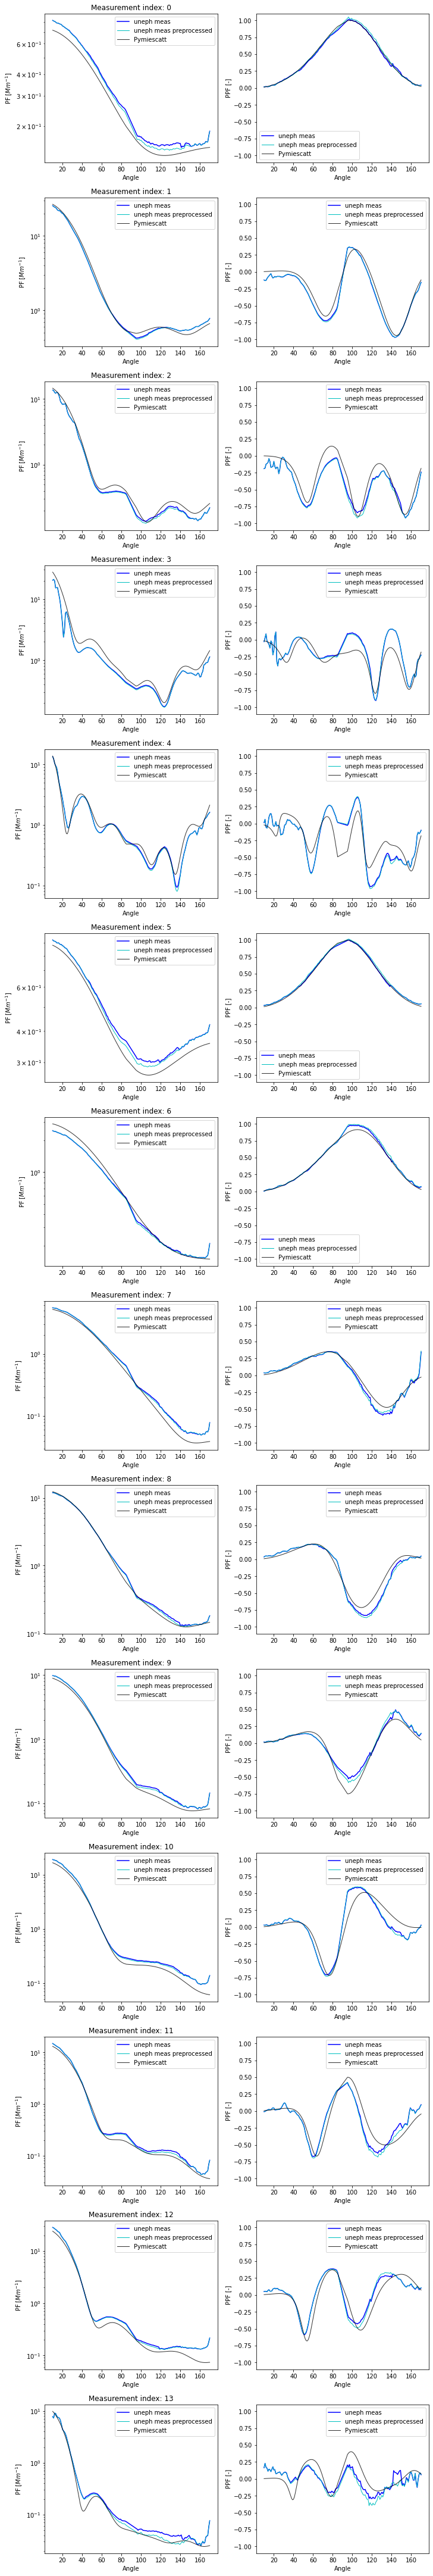

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements.jpg')


In [14]:
qoi_meas

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199561     -0.208397     -0.212769     -0.221579     -0.234253   
1       3.236400      3.210953      3.190095      3.176939      3.142313   
2       2.614309      2.599025      2.532035      2.501506      2.535926   
3       3.012159      3.042673      2.985023      2.721631      2.733629   
4       2.602780      2.517139      2.344692      2.260295      2.197533   
5      -0.078021     -0.086697     -0.089969     -0.092307     -0.103138   
6       0.909239      0.896267      0.894234      0.889193      0.879337   
7       1.706418      1.700815      1.693317      1.691437      1.682543   
8       2.480806      2.476104      2.466042      2.455219      2.440502   
9       2.285199      2.280999      2.267148      2.266079      2.251123   
10      2.953820      2.940282      2.928117      2.916315      2.901677   
11      2.705545      2.674133      2.646023      2.616575      2.582985   
12      3.344605      3.322056      3.289388      3.252338      3.225176   
13      2.050860      1.989798      2.208283      2.193497      2.092762   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235109     -0.238511     -0.246926     -0.250181     -0.257187  ...   
1       3.098304      3.084847      3.079266      3.058560      3.015682  ...   
2       2.528479      2.459868      2.360886      2.213174      2.163184  ...   
3       2.731514      2.528046      2.344214      2.093175      1.752889  ...   
4       2.012000      1.744945      1.527114      1.370812      1.182601  ...   
5      -0.106837     -0.104405     -0.114490     -0.119551     -0.120348  ...   
6       0.868961      0.861646      0.855756      0.845514      0.832707  ...   
7       1.665529      1.647456      1.628904      1.612665      1.597579  ...   
8       2.423184      2.406314      2.388203      2.377156      2.365967  ...   
9       2.228715      2.210645      2.194110      2.171250      2.145426  ...   
10      2.867769      2.833496      2.811605      2.797327      2.768091  ...   
11      2.557651      2.534402      2.504505      2.456602      2.404585  ...   
12      3.172034      3.146335      3.119594      3.031304      2.951275  ...   
13      2.025248      2.013026      1.976347      1.868395      1.688473  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.062705       0.058236       0.053258       0.041816       0.041821   
1       -0.442089      -0.402139      -0.369479      -0.335306      -0.310288   
2       -0.739106      -0.691336      -0.679427      -0.630740      -0.600472   
3       -0.575264      -0.536323      -0.507552      -0.553375      -0.525443   
4       -0.522459      -0.503661      -0.471962      -0.416038      -0.316883   
5        0.081435       0.078506       0.070624       0.065684       0.061138   
6        0.143271       0.121091       0.095935       0.084857       0.076034   
7       -0.085548      -0.104193      -0.112898      -0.077543      -0.072952   
8        0.021192       0.023545       0.023041       0.017631       0.031869   
9        0.239359       0.201787       0.167051       0.162393       0.164037   
10      -0.092794      -0.076136      -0.073104      -0.087072      -0.075848   
11       0.006520       0.018406       0.006810      -0.032775      -0.008622   
12       0.129906       0.116541       0.098241       0.084517       0.102488   
13       0.047823      -0.017431      -0.018607       0.080858      -0.055929   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.047582       0.038348       0.036427       0.037912       0.040365  
1       -0.296504      -0.274272      -0.237057      -0.190713      -0.155765  
2       -0.533391      -0.463790      -0.395754      -0.312426      -0.241548  
3       -0.337376      -0.288274      -0.286020      -0.250328      -0.227706  
4       -0.171938      -0.12752

In [15]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199192     -0.208090     -0.212374     -0.221117     -0.234133   
1       3.236607      3.211170      3.190303      3.177109      3.142479   
2       2.614584      2.599239      2.532223      2.501703      2.536171   
3       3.012439      3.042962      2.985233      2.721838      2.733857   
4       2.603044      2.517263      2.344944      2.260373      2.197514   
5      -0.077880     -0.086597     -0.089768     -0.092049     -0.103094   
6       0.909411      0.896239      0.894288      0.889330      0.879361   
7       1.706462      1.700790      1.693286      1.691406      1.682511   
8       2.481020      2.476240      2.466186      2.455370      2.440629   
9       2.285434      2.281109      2.267237      2.266178      2.251213   
10      2.954085      2.940469      2.928309      2.916510      2.901856   
11      2.705830      2.674323      2.646197      2.616734      2.583123   
12      3.344719      3.322163      3.289512      3.252513      3.225334   
13      2.051376      1.990165      2.208616      2.193612      2.092870   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235177     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.098492      3.085057      3.079462      3.058732      3.015831  ...   
2       2.528741      2.460123      2.361134      2.213312      2.163275  ...   
3       2.731787      2.528389      2.344447      2.093368      1.753163  ...   
4       2.012040      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.106913     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.868984      0.861694      0.855720      0.845499      0.832738  ...   
7       1.665515      1.647445      1.628860      1.612596      1.597519  ...   
8       2.423309      2.406455      2.388337      2.377311      2.366132  ...   
9       2.228814      2.210759      2.194205      2.171341      2.145541  ...   
10      2.867930      2.833671      2.811790      2.797430      2.768145  ...   
11      2.557807      2.534591      2.504700      2.456799      2.404771  ...   
12      3.172168      3.146513      3.119785      3.031482      2.951414  ...   
13      2.025392      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

In [16]:
qoi_meas_pymiescatt

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.330722 -0.335406 -0.340532 -0.346100 -0.352109 -0.358556 -0.365442   
1   3.279742  3.262431  3.243463  3.222838  3.200552  3.176605  3.150995   
2   2.681297  2.656183  2.628618  2.598585  2.566067  2.531043  2.493492   
3   3.316615  3.261761  3.201326  3.135219  3.063343  2.985599  2.901892   
4   2.626295  2.509020  2.377339  2.230161  2.066209  1.884021  1.681980   
5  -0.126536 -0.130674 -0.135202 -0.140119 -0.145425 -0.151117 -0.157195   
6   1.057597  1.052010  1.045895  1.039251  1.032082  1.024387  1.016169   
7   1.647584  1.639660  1.630986  1.621563  1.611393  1.600476  1.588815   
8   2.512474  2.502008  2.490545  2.478086  2.464630  2.450179  2.434731   
9   2.191082  2.179161  2.166100  2.151899  2.136556  2.120069  2.102438   
10  2.817757  2.801281  2.783222  2.763577  2.742340  2.719508  2.695075   
11  2.576809  2.554683  2.530408  2.503972  2.475362  2.444564  2.411563   
12  3.176521  3.147132  3.114848  3.079640  3.041478  3.000329  2.956156   
13  2.287451  2.235916  2.179083  2.116835  2.049042  1.975553  1.896204   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.372765 -0.380522 -0.388714  ...  0.075290  0.067477  0.060104  0.053171   
1   3.123719  3.094777  3.064166  ... -0.426074 -0.384111 -0.343685 -0.305037   
2   2.453391  2.410716  2.365439  ... -0.638724 -0.584372 -0.528777 -0.473179   
3   2.812132  2.716245  2.614180  ... -0.659852 -0.611053 -0.555606 -0.496657   
4   1.458435  1.212017  0.942395  ... -0.690478 -0.659288 -0.610779 -0.549424   
5  -0.163656 -0.170499 -0.177722  ...  0.064931  0.058182  0.051817  0.045832   
6   1.007428  0.998166  0.988385  ...  0.105330  0.094565  0.084371  0.074750   
7   1.576411  1.563266  1.549383  ... -0.108208 -0.095673 -0.084043 -0.073306   
8   2.418287  2.400848  2.382413  ...  0.047522  0.044453  0.041145  0.037672   
9   2.083660  2.063735  2.042660  ...  0.165475  0.150214  0.135351  0.120977   
10  2.669038  2.641389  2.612124  ... -0.001929 -0.003679 -0.004958 -0.005815   
11  2.376343  2.338885  2.299171  ... -0.171137 -0.153189 -0.135917 -0.119461   
12  2.908920  2.858577  2.805079  ...  0.218257  0.202657  0.186377  0.169658   
13  1.810808  1.719155  1.621013  ...  0.119823  0.123663  0.124947  0.123646   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.046673  0.040608  0.034975  0.029769  0.024990  0.020634  
1  -0.268364 -0.233820 -0.201520 -0.171547 -0.143958 -0.118788  
2  -0.418641 -0.366030 -0.316024 -0.269131 -0.225709 -0.185992  
3  -0.436943 -0.378629 -0.323275 -0.271903 -0.225094 -0.183102  
4  -0.480965 -0.410948 -0.343714 -0.282059 -0.227385 -0.180077  
5   0.040226  0.034994  0.030136  0.025648  0.021529  0.017775  
6   0.065706  0.057241  0.049357  0.042055  0.035337  0.029202  
7  -0.063444 -0.054432 -0.046241 -0.038838 -0.032189 -0.026258  
8   0.034104  0.030503  0.026928  0.023431  0.020058  0.016851  
9   0.107174  0.094014  0.081560  0.069867  0.058980  0.048939  
10 -0.006301 -0.006468 -0.006367 -0.006051 -0.005569 -0.004967  
11 -0.103941 -0.089454 -0.076073 -0.063843 -0.052787 -0.042903  
12  0.152746  0.135886  0.119318  0.103261  0.087918  0.073464  
13  0.119858  0.113797  0.105778  0.096195  0.085485  0.074104  

[14 rows x 304 columns]

# Make predictions with the forward model fw
## from phase functions to aerosol properties

In [17]:
# prediction of measurement data
dvar_meas_pred = surr_fw.predict(qoi_meas.values)
dvar_meas_pred = pd.DataFrame(data =dvar_meas_pred, columns = dvar_meas.columns)
dvar_meas_pred_2qoi = dvar_meas_pred.copy()
dvar_meas_pred = np.exp(dvar_meas_pred)
dvar_meas_pred['GSD']=dvar_meas_pred['GSD']+1
dvar_meas_pred['n']=dvar_meas_pred['n']+1.33
dvar_meas_pred['RmedianV'] = dvar_meas_pred['RmedianV']*1e-3 # in um
dvar_meas_pred.to_csv(f'{plot_dir}/dvar_meas_pred.csv')
dvar_meas_pred

Vtot  RmedianV       GSD         n         k
0    0.910618  0.093884  1.097289  1.645462  0.066140
1    6.025717  0.227211  1.011153  1.597120  0.001253
2    2.115229  0.256311  1.014810  1.627862  0.079491
3    3.038614  0.462482  1.018748  1.636325  0.000327
4   21.944051  1.501487  1.293781  1.372507  0.000017
5    2.287399  0.075076  1.066979  1.559686  0.114741
6    1.811650  0.113525  1.104360  1.608093  0.071220
7    2.224187  0.173139  1.094541  1.651116  0.373277
8    3.129779  0.157965  1.044953  1.679924  0.337662
9    2.942658  0.190146  1.144805  1.716933  0.356507
10   4.648734  0.246386  1.060774  1.713353  0.279362
11   2.404580  0.259991  1.068565  1.678677  0.192048
12   5.287827  0.379773  1.071252  1.543223  0.346124
13   1.893777  0.282464  1.038647  1.427615  0.221957

In [18]:
dvar_meas_pred_2qoi

Vtot  RmedianV       GSD         n          k
0  -0.093632  4.542062 -2.330074 -1.153717  -2.715975
1   1.796037  5.425881 -4.496050 -1.320057  -6.682080
2   0.749163  5.546392 -4.212470 -1.211124  -2.532106
3   1.111401  6.136608 -3.976680 -1.183110  -8.024779
4   3.088496  7.314212 -1.224921 -3.158075 -10.994058
5   0.827415  4.318496 -2.703372 -1.471040  -2.165075
6   0.594238  4.732024 -2.259905 -1.279801  -2.641982
7   0.799392  5.154096 -2.358723 -1.135951  -0.985434
8   1.140962  5.062374 -3.102148 -1.050040  -1.085711
9   1.079313  5.247794 -1.932367 -0.949503  -1.031401
10  1.536595  5.506900 -2.800594 -0.958799  -1.275247
11  0.877375  5.560646 -2.679971 -1.053609  -1.650010
12  1.665407  5.939574 -2.641533 -1.545415  -1.060958
13  0.638573  5.643553 -3.253299 -2.326728  -1.505269

In [19]:
# prediction of processed measurement data
dvar_meas_preprocessed_pred = surr_fw.predict(qoi_meas_preprocessed.values)
dvar_meas_preprocessed_pred = pd.DataFrame(data =dvar_meas_preprocessed_pred, columns = dvar_meas.columns)
dvar_meas_preprocessed_pred_2qoi = dvar_meas_preprocessed_pred.copy()
dvar_meas_preprocessed_pred = np.exp(dvar_meas_preprocessed_pred)
dvar_meas_preprocessed_pred['GSD']=dvar_meas_preprocessed_pred['GSD']+1
dvar_meas_preprocessed_pred['n']=dvar_meas_preprocessed_pred['n']+1.33
dvar_meas_preprocessed_pred['RmedianV'] = dvar_meas_preprocessed_pred['RmedianV']*1e-3 # in um
dvar_meas_preprocessed_pred.to_csv(f'{plot_dir}/dvar_meas_preprocessed_pred.csv')
dvar_meas_preprocessed_pred

Vtot  RmedianV       GSD         n         k
0    0.934942  0.091829  1.067442  1.557017  0.012373
1    5.911455  0.225599  1.010382  1.599752  0.001077
2    1.863553  0.252162  1.010393  1.607490  0.057869
3    2.872259  0.454508  1.018788  1.628458  0.000270
4   22.450056  1.498756  1.288511  1.366955  0.000010
5    2.126477  0.077721  1.074290  1.528719  0.098010
6    1.701467  0.114076  1.095710  1.585326  0.031157
7    2.312000  0.169102  1.118743  1.638630  0.360004
8    3.018126  0.160631  1.042652  1.687786  0.320129
9    2.842128  0.191757  1.117259  1.709519  0.339647
10   4.564810  0.245065  1.058817  1.687145  0.277778
11   2.166741  0.253928  1.059293  1.613975  0.146684
12   5.371876  0.377311  1.066592  1.514495  0.286778
13   1.315447  0.278027  1.008515  1.407253  0.086059

In [20]:
# prediction of with pymiescatt predicted measurement data
dvar_meas_pymiescatt_pred = surr_fw.predict(qoi_meas_pymiescatt.values)
dvar_meas_pymiescatt_pred = pd.DataFrame(data =dvar_meas_pymiescatt_pred, columns = dvar_meas.columns)
dvar_meas_pymiescatt_pred_2qoi = dvar_meas_pymiescatt_pred.copy()

dvar_meas_pymiescatt_pred = np.exp(dvar_meas_pymiescatt_pred)
dvar_meas_pymiescatt_pred['GSD']=dvar_meas_pymiescatt_pred['GSD']+1
dvar_meas_pymiescatt_pred['n']=dvar_meas_pymiescatt_pred['n']+1.33
dvar_meas_pymiescatt_pred['RmedianV'] = dvar_meas_pymiescatt_pred['RmedianV']*1e-3 # in um
dvar_meas_pymiescatt_pred.to_csv(f'{plot_dir}/dvar_meas_pymiescatt_pred.csv')
dvar_meas_pymiescatt_pred

Vtot  RmedianV       GSD         n         k
0   0.912262  0.094342  1.066405  1.577486  0.069990
1   2.995471  0.238684  1.044495  1.581391  0.008118
2   1.136022  0.312982  1.042429  1.600180  0.000557
3   3.713086  0.403884  1.057717  1.567905  0.002464
4   5.131971  0.637889  1.083262  1.584748  0.000974
5   2.182396  0.078229  1.063312  1.597827  0.071907
6   2.002607  0.117037  1.101008  1.615324  0.233066
7   2.039865  0.146583  1.080952  1.595629  0.218701
8   3.680952  0.174894  1.078479  1.616455  0.248116
9   2.276174  0.191310  1.067296  1.619656  0.203037
10  3.655552  0.219333  1.081996  1.595884  0.213604
11  2.525939  0.260408  1.081926  1.598199  0.219872
12  4.423989  0.304384  1.069328  1.603069  0.235077
13  1.860859  0.377207  1.073769  1.620426  0.223355

# Make predictions with the forward model iv
## from aerosol properties to phase functions

In [21]:
dvar_meas_2qoi = dvar_meas.copy()
dvar_meas_2qoi['RmedianV']= dvar_meas_2qoi['RmedianV']*1e3
dvar_meas_2qoi['GSD']= dvar_meas_2qoi['GSD']-1
dvar_meas_2qoi['n']= dvar_meas_2qoi['n']-1.33
dvar_meas_2qoi = np.log(dvar_meas_2qoi.astype('float64'))
dvar_meas_2qoi


Vtot  RmedianV       GSD         n         k
0  -0.170104  4.609785 -3.218876 -1.347074 -9.210340
1   1.130124  5.528602 -2.995732 -1.347074 -9.210340
2   0.316112  5.710924 -2.995732 -1.347074 -9.210340
3   1.259201  5.998606 -2.995732 -1.347074 -9.210340
4   1.560907  6.221750 -2.995732 -1.347074 -9.210340
5   0.797529  4.339768 -2.407946 -1.237874 -1.500584
6   0.733104  4.767212 -2.407946 -1.237874 -1.500584
7   0.764918  5.028404 -2.525729 -1.237874 -1.500584
8   1.354122  5.182555 -2.525729 -1.237874 -1.500584
9   0.901635  5.260757 -2.659260 -1.237874 -1.500584
10  1.327906  5.433869 -2.525729 -1.237874 -1.500584
11  0.973193  5.578451 -2.525729 -1.237874 -1.500584
12  1.529973  5.717516 -2.659260 -1.237874 -1.500584
13  0.694389  5.977485 -2.525729 -1.237874 -1.500584

In [22]:
# qoi: prediction of true data
qoi_pred = surr_iv.predict(dvar_meas_2qoi)
qoi_pred = pd.DataFrame(qoi_pred, columns = qoi_col_list)
qoi_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_pred


F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   0.013654 -0.100267 -0.122151 -0.185384 -0.248088 -0.266920 -0.314799   
1   2.774044  2.772403  2.894843  2.918389  2.890717  2.960247  3.032738   
2   2.093080  2.114197  2.257979  2.304309  2.292104  2.314491  2.348406   
3   2.499474  2.522861  2.703028  2.720092  2.771960  2.723064  2.776076   
4   2.753665  2.691358  2.715634  2.682460  2.554881  2.460645  2.393850   
5  -0.106100 -0.114479 -0.125093 -0.128372 -0.142300 -0.145199 -0.157187   
6   1.012748  1.001795  1.006071  1.011706  1.010596  1.015215  1.013354   
7   1.618348  1.617086  1.592816  1.591475  1.582386  1.576474  1.561613   
8   2.471972  2.474949  2.470362  2.464985  2.449594  2.441443  2.422663   
9   2.173981  2.157087  2.139894  2.121860  2.099771  2.092608  2.075170   
10  2.876447  2.822507  2.785028  2.759976  2.744761  2.725404  2.709900   
11  2.576400  2.540225  2.527578  2.503100  2.490873  2.468511  2.450568   
12  3.141492  3.096216  3.070118  3.037222  3.009880  2.972497  2.933830   
13  2.250278  2.226378  2.179064  2.154904  2.107211  2.054625  1.977934   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.325716 -0.318537 -0.343987  ...  0.149698  0.140376  0.117283  0.106489   
1   2.948077  2.944164  2.908675  ... -0.490910 -0.435335 -0.369603 -0.318865   
2   2.255605  2.224212  2.189845  ... -0.739352 -0.674255 -0.594611 -0.526204   
3   2.698905  2.671994  2.635782  ... -0.976611 -0.908350 -0.827368 -0.745920   
4   2.208870  2.080233  1.942815  ... -0.869651 -0.821260 -0.763000 -0.692839   
5  -0.161218 -0.170664 -0.176632  ...  0.067336  0.061327  0.054106  0.049609   
6   1.006787  1.005005  0.997546  ...  0.109580  0.100685  0.090830  0.082420   
7   1.552695  1.526911  1.509809  ... -0.136721 -0.125478 -0.111782 -0.099850   
8   2.397526  2.372999  2.344753  ...  0.023575  0.024602  0.025151  0.025213   
9   2.051035  2.017303  1.994762  ...  0.172633  0.156621  0.141952  0.126649   
10  2.686967  2.671033  2.631080  ... -0.045752 -0.043583 -0.042780 -0.039613   
11  2.413022  2.376639  2.330804  ... -0.202535 -0.182101 -0.164642 -0.147121   
12  2.896136  2.854377  2.805007  ...  0.214926  0.203423  0.188091  0.173984   
13  1.891563  1.793069  1.683607  ...  0.174049  0.174052  0.176071  0.169242   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.084923  0.071731  0.058540  0.041088  0.026520  0.022537  
1  -0.266659 -0.226191 -0.173804 -0.153764 -0.126707 -0.100306  
2  -0.452773 -0.393618 -0.319909 -0.273893 -0.227073 -0.184477  
3  -0.650058 -0.571318 -0.484066 -0.412072 -0.340795 -0.282796  
4  -0.607018 -0.537399 -0.453162 -0.390055 -0.327210 -0.268358  
5   0.043414  0.038783  0.033191  0.028415  0.024600  0.021267  
6   0.073534  0.066046  0.057410  0.048936  0.042138  0.035363  
7  -0.088675 -0.077304 -0.066479 -0.056323 -0.046050 -0.038516  
8   0.023782  0.023428  0.021338  0.018907  0.016619  0.014653  
9   0.111272  0.097233  0.084081  0.070293  0.059455  0.048159  
10 -0.037404 -0.032770 -0.029916 -0.026599 -0.023842 -0.018151  
11 -0.130306 -0.113117 -0.099198 -0.084866 -0.071613 -0.059737  
12  0.157005  0.140114  0.123131  0.105605  0.088606  0.073237  
13  0.160829  0.149596  0.137177  0.122789  0.106540  0.090052  

[14 rows x 304 columns]

In [23]:
# qoi: prediction of measurement data

qoi_meas_pred = surr_iv.predict(dvar_meas_pred_2qoi)
qoi_meas_pred = pd.DataFrame(qoi_meas_pred, columns = qoi_col_list)
qoi_meas_pred.to_csv(f'{plot_dir}/qoi_meas_pred.csv')
qoi_meas_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.340863 -0.352131 -0.350121 -0.356556 -0.359448 -0.370564 -0.379975   
1   3.552473  3.626642  3.663863  3.682511  3.818836  3.860062  3.901277   
2   2.362975  2.487192  2.474422  2.496748  2.508050  2.422371  2.377810   
3   1.950264  1.924089  1.854531  1.794789  1.545437  1.536904  1.391129   
4   4.111429  3.713856  3.603147  3.339776  3.116784  2.921187  2.789899   
5  -0.401780 -0.410682 -0.418849 -0.425124 -0.434558 -0.433120 -0.438326   
6   0.871986  0.857263  0.855629  0.851150  0.848864  0.843672  0.836788   
7   1.924158  1.927993  1.899631  1.881701  1.850747  1.834701  1.791487   
8   2.159023  2.158860  2.147520  2.136599  2.132579  2.115174  2.090473   
9   2.387500  2.373437  2.363634  2.339824  2.314693  2.301774  2.275362   
10  2.978351  2.926516  2.923934  2.891767  2.893490  2.896688  2.895698   
11  2.503125  2.475001  2.473321  2.442257  2.427050  2.408959  2.390620   
12  3.263702  3.225846  3.151495  3.112688  3.040253  2.976269  2.887630   
13  2.227700  2.187378  2.081523  2.066206  2.065030  1.995426  1.944415   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.385777 -0.394556 -0.403720  ...  0.074006  0.066893  0.059138  0.053492   
1   3.956513  3.916886  3.991223  ... -0.451149 -0.416361 -0.370656 -0.336944   
2   2.370900  2.327504  2.330024  ... -0.486024 -0.445573 -0.397610 -0.363808   
3   1.219278  1.112027  0.977147  ... -0.216006 -0.183539 -0.156309 -0.117165   
4   2.687555  2.549750  2.323200  ... -0.438423 -0.469216 -0.512888 -0.508197   
5  -0.447796 -0.456447 -0.464235  ...  0.065145  0.058193  0.051615  0.045620   
6   0.829076  0.821620  0.815941  ...  0.097662  0.087802  0.077771  0.068971   
7   1.769111  1.730363  1.702354  ...  0.088320  0.082193  0.075742  0.071318   
8   2.072074  2.035026  2.016500  ... -0.122306 -0.108446 -0.091313 -0.077476   
9   2.249921  2.211533  2.185898  ...  0.152616  0.140707  0.126663  0.113935   
10  2.868289  2.835130  2.803339  ... -0.276392 -0.251687 -0.229500 -0.207698   
11  2.352294  2.320697  2.281664  ... -0.315848 -0.290163 -0.265417 -0.241005   
12  2.793068  2.684316  2.574428  ...  0.062406  0.062768  0.068958  0.069215   
13  1.945156  1.885367  1.862494  ...  0.042833  0.054362  0.060834  0.066163   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.047194  0.041630  0.035409  0.029893  0.026042  0.022299  
1  -0.305089 -0.274046 -0.244546 -0.211719 -0.181004 -0.161971  
2  -0.316932 -0.283563 -0.252207 -0.213445 -0.178515 -0.154327  
3  -0.081653 -0.040996 -0.024818 -0.011641 -0.012233  0.007646  
4  -0.501648 -0.516258 -0.500713 -0.508353 -0.459237 -0.411506  
5   0.038960  0.033618  0.028451  0.023569  0.019277  0.015975  
6   0.060569  0.052899  0.045147  0.038180  0.032495  0.027034  
7   0.061858  0.054944  0.047690  0.039990  0.034339  0.028118  
8  -0.066683 -0.055271 -0.044540 -0.037104 -0.028736 -0.023412  
9   0.099472  0.086193  0.072834  0.059248  0.049122  0.039059  
10 -0.187821 -0.166729 -0.149362 -0.132459 -0.112977 -0.097834  
11 -0.217095 -0.191210 -0.169662 -0.147506 -0.124866 -0.105076  
12  0.068274  0.065734  0.064471  0.059963  0.054616  0.049002  
13  0.070715  0.064093  0.059211  0.058527  0.052156  0.045077  

[14 rows x 304 columns]

In [24]:
# qoi: prediction of processed measurement data

qoi_meas_preprocessed_pred = surr_iv.predict(dvar_meas_preprocessed_pred_2qoi)
qoi_meas_preprocessed_pred = pd.DataFrame(qoi_meas_preprocessed_pred, columns = qoi_col_list)
qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/qoi_meas_preprocessed_pred.csv')
qoi_meas_preprocessed_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.681166 -0.686474 -0.692325 -0.693115 -0.688117 -0.696113 -0.701807   
1   3.491077  3.568485  3.606939  3.633181  3.771330  3.818268  3.862586   
2   2.207586  2.384716  2.366121  2.405881  2.427947  2.342641  2.280964   
3   1.964825  1.936908  1.907244  1.828741  1.590083  1.579013  1.461164   
4   4.395579  3.985246  3.845940  3.538876  3.267533  3.036874  2.861832   
5  -0.469277 -0.483761 -0.486797 -0.494909 -0.502665 -0.499409 -0.501323   
6   0.789263  0.783323  0.779276  0.775407  0.770614  0.756394  0.745085   
7   1.919786  1.912961  1.884207  1.869338  1.839580  1.828845  1.792101   
8   2.162376  2.154683  2.135896  2.114861  2.103103  2.082133  2.054651   
9   2.378878  2.360990  2.353527  2.329012  2.303964  2.298224  2.275045   
10  2.937343  2.890544  2.888740  2.860699  2.864990  2.871447  2.873357   
11  2.457504  2.440647  2.425195  2.415716  2.379331  2.369014  2.334510   
12  3.322541  3.284627  3.195453  3.149311  3.068141  2.998744  2.903328   
13  1.494262  1.649931  1.683040  1.709197  1.599665  1.589224  1.576506   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.705548 -0.714828 -0.718738  ...  0.062254  0.053821  0.047569  0.041690   
1   3.919112  3.881627  3.955781  ... -0.437011 -0.401949 -0.356476 -0.323384   
2   2.296721  2.234123  2.249276  ... -0.469748 -0.426649 -0.371530 -0.333787   
3   1.293475  1.202100  1.093431  ... -0.283640 -0.248985 -0.217443 -0.176441   
4   2.755701  2.570771  2.334777  ... -0.423259 -0.465279 -0.521605 -0.523492   
5  -0.513734 -0.521020 -0.529236  ...  0.069414  0.062092  0.055144  0.048879   
6   0.738291  0.729380  0.726449  ...  0.092471  0.082853  0.073292  0.064669   
7   1.778054  1.750808  1.730440  ...  0.067158  0.063665  0.057928  0.055400   
8   2.032726  1.995208  1.975115  ... -0.095460 -0.084490 -0.069306 -0.057766   
9   2.251125  2.214765  2.189410  ...  0.197435  0.179902  0.160387  0.142718   
10  2.849535  2.817820  2.787084  ... -0.261939 -0.238636 -0.216303 -0.195482   
11  2.285751  2.244549  2.200988  ... -0.493713 -0.459602 -0.423993 -0.387135   
12  2.816701  2.709959  2.609858  ...  0.025431  0.026830  0.034713  0.036621   
13  1.508213  1.436173  1.412719  ... -0.638277 -0.582648 -0.516936 -0.467743   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.036219  0.030918  0.026781  0.022507  0.019053  0.016147  
1  -0.292416 -0.262139 -0.233929 -0.202695 -0.173711 -0.155640  
2  -0.286952 -0.254958 -0.224826 -0.187907 -0.154854 -0.134813  
3  -0.136187 -0.091696 -0.069227 -0.050710 -0.043106 -0.018625  
4  -0.523815 -0.550128 -0.534657 -0.545047 -0.494742 -0.448661  
5   0.041759  0.036092  0.030639  0.024975  0.020230  0.016578  
6   0.057207  0.049345  0.041890  0.036246  0.030798  0.025669  
7   0.047891  0.041859  0.036013  0.030102  0.025556  0.021118  
8  -0.049536 -0.040072 -0.031255 -0.026109 -0.019394 -0.015903  
9   0.123250  0.106490  0.089850  0.072376  0.060007  0.047836  
10 -0.176512 -0.156328 -0.139875 -0.124291 -0.105975 -0.091807  
11 -0.352020 -0.314807 -0.277161 -0.242331 -0.208703 -0.176048  
12  0.036979  0.035839  0.036645  0.035387  0.032372  0.029057  
13 -0.405322 -0.362082 -0.307169 -0.270512 -0.225557 -0.186956  

[14 rows x 304 columns]

In [25]:
# qoi: prediction of with pymiescatt predicted measurement data

qoi_meas_pymiescatt_pred=surr_iv.predict(dvar_meas_pymiescatt_pred_2qoi)
qoi_meas_pymiescatt_pred = pd.DataFrame(qoi_meas_pymiescatt_pred, columns = qoi_col_list)
qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/qoi_meas_pymiescatt_pred.csv')
qoi_meas_pymiescatt_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0  -0.523612 -0.534573 -0.544850 -0.553840 -0.559906 -0.566557 -0.576972   
1   3.099677  3.108125  3.106273  3.091387  3.067771  3.087673  3.093118   
2   2.310192  2.309423  2.287769  2.263066  2.194486  2.146260  2.079255   
3   3.272586  3.295310  3.246580  3.202980  3.168115  3.076049  2.962403   
4   3.088801  2.931843  2.748667  2.622701  2.422083  2.194652  1.954408   
5  -0.198091 -0.204917 -0.213987 -0.222230 -0.230779 -0.233083 -0.240155   
6   0.927238  0.919017  0.927904  0.932975  0.932428  0.935373  0.935326   
7   1.450034  1.451620  1.434615  1.427327  1.412205  1.406107  1.392421   
8   2.395810  2.398251  2.383021  2.374543  2.357744  2.346558  2.322816   
9   2.119471  2.099236  2.076066  2.060173  2.038783  2.032397  2.015585   
10  2.752972  2.701882  2.659929  2.648004  2.630427  2.625428  2.612721   
11  2.483536  2.446596  2.437181  2.416891  2.402925  2.387269  2.373119   
12  3.107884  3.056928  3.021683  2.986376  2.955798  2.913205  2.870431   
13  2.239722  2.202336  2.147479  2.111188  2.053945  1.996264  1.922417   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  -0.585751 -0.597148 -0.607470  ...  0.071688  0.063480  0.056676  0.050790   
1   3.084057  3.052984  3.041041  ... -0.438316 -0.388487 -0.340587 -0.297086   
2   2.003627  1.928963  1.873314  ... -0.522906 -0.473152 -0.415848 -0.367032   
3   2.920189  2.796445  2.712382  ... -0.708829 -0.671888 -0.615367 -0.556246   
4   1.741327  1.526247  1.347113  ... -0.731428 -0.722115 -0.697294 -0.659343   
5  -0.245577 -0.254752 -0.263280  ...  0.066667  0.059827  0.053073  0.047343   
6   0.930091  0.930344  0.923762  ...  0.107579  0.099079  0.089108  0.080737   
7   1.379151  1.355991  1.344464  ... -0.075135 -0.070327 -0.064531 -0.058435   
8   2.301924  2.274687  2.248910  ...  0.014779  0.016163  0.017516  0.018603   
9   1.991976  1.960633  1.937676  ...  0.141410  0.128055  0.116021  0.103486   
10  2.598421  2.589763  2.557117  ...  0.169788  0.154906  0.137582  0.123159   
11  2.333253  2.298334  2.245926  ... -0.237490 -0.213901 -0.192106 -0.170885   
12  2.832929  2.788771  2.739166  ...  0.242092  0.228782  0.211964  0.196333   
13  1.839952  1.751595  1.654949  ...  0.104325  0.108962  0.113431  0.111760   

     PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0   0.043616  0.037886  0.032366  0.026923  0.022620  0.019015  
1  -0.256339 -0.224674 -0.191837 -0.167163 -0.139136 -0.117329  
2  -0.319427 -0.276588 -0.232201 -0.196211 -0.166534 -0.137076  
3  -0.493711 -0.433596 -0.377589 -0.319709 -0.261540 -0.217440  
4  -0.611286 -0.566470 -0.504896 -0.451434 -0.399996 -0.341584  
5   0.040727  0.035453  0.029835  0.024983  0.021119  0.017691  
6   0.072203  0.064764  0.056122  0.047656  0.041257  0.034266  
7  -0.053469 -0.048876 -0.043760 -0.037594 -0.031515 -0.027491  
8   0.017636  0.017543  0.016075  0.014426  0.013062  0.011391  
9   0.091021  0.079453  0.068890  0.058054  0.049221  0.040085  
10  0.107266  0.093967  0.080158  0.067611  0.055360  0.047383  
11 -0.150744 -0.129571 -0.112108 -0.096340 -0.081191 -0.066892  
12  0.177249  0.158227  0.139873  0.120198  0.101016  0.084037  
13  0.108445  0.103097  0.096421  0.088258  0.077024  0.066374  

[14 rows x 304 columns]

In [26]:
np.exp(qoi_meas_pred)

F11_10     F11_11     F11_12     F11_13     F11_14     F11_15  \
0    0.711157   0.703188   0.704603   0.700083   0.698062   0.690345   
1   34.899525  37.586408  39.011749  39.746052  45.551164  47.468277   
2   10.622503  12.027455  11.874845  12.142940  12.280960  11.272555   
3    7.030545   6.848905   6.388699   6.018207   4.690023   4.650169   
4   61.033894  41.011662  36.713600  28.212807  22.573658  18.563311   
5    0.669128   0.663198   0.657803   0.653689   0.647551   0.648482   
6    2.391656   2.356702   2.352853   2.342339   2.336991   2.324889   
7    6.849376   6.875695   6.683424   6.564659   6.364575   6.263261   
8    8.662670   8.661258   8.563596   8.470576   8.436595   8.291030   
9   10.886248  10.734218  10.629514  10.379405  10.121814   9.991889   
10  19.655378  18.662503  18.614376  18.025130  18.056224  18.114050   
11  12.220619  11.881717  11.861770  11.498962  11.325425  11.122381   
12  26.146155  25.174856  23.370986  22.481397  20.910524  19.614502   
13   9.278504   8.911818   8.016670   7.894813   7.885534   7.355333   

       F11_16     F11_17     F11_18     F11_19  ...   PPF_161   PPF_162  \
0    0.683878   0.679922   0.673979   0.667831  ...  1.076813  1.069181   
1   49.465585  52.274748  50.243730  54.121018  ...  0.636896  0.659442   
2   10.781265  10.707024  10.252323  10.278189  ...  0.615067  0.640457   
3    4.019386   3.384745   3.040515   2.656864  ...  0.805730  0.832320   
4   16.279376  14.695707  12.803905  10.208287  ...  0.645053  0.625493   
5    0.645115   0.639035   0.633531   0.628616  ...  1.067314  1.059919   
6    2.308939   2.291200   2.274181   2.261303  ...  1.102591  1.091772   
7    5.998367   5.865637   5.642700   5.486847  ...  1.092337  1.085666   
8    8.088740   7.941275   7.652453   7.511987  ...  0.884878  0.897227   
9    9.731438   9.486986   9.129703   8.898633  ...  1.164878  1.151087   
10  18.096123  17.606869  17.032608  16.499649  ...  0.758516  0.777488   
11  10.920258  10.509647  10.182766   9.792960  ...  0.729170  0.748141   
12  17.950721  16.331045  14.648175  13.123806  ...  1.064394  1.064780   
13   6.989545   6.994720   6.588772   6.439776  ...  1.043763  1.055866   

     PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169  \
0   1.060922  1.054949  1.048325  1.042509  1.036043  1.030345  1.026384   
1   0.690281  0.713949  0.737058  0.760297  0.783060  0.809192  0.834432   
2   0.671924  0.695025  0.728380  0.753096  0.777084  0.807797  0.836512   
3   0.855295  0.889438  0.921592  0.959833  0.975488  0.988426  0.987841   
4   0.598764  0.601579  0.605532  0.596749  0.606099  0.601485  0.631766   
5   1.052970  1.046676  1.039729  1.034189  1.028859  1.023849  1.019464   
6   1.080875  1.071405  1.062441  1.054323  1.046182  1.038918  1.033029   
7   1.078685  1.073923  1.063812  1.056482  1.048845  1.040801  1.034936   
8   0.912732  0.925450  0.935491  0.946229  0.956438  0.963576  0.971673   
9   1.135035  1.120679  1.104588  1.090017  1.075552  1.061038  1.050349   
10  0.794931  0.812452  0.828763  0.846429  0.861257  0.875939  0.893171   
11  0.766886  0.785838  0.804854  0.825959  0.843950  0.862857  0.882615   
12  1.071391  1.071666  1.070658  1.067943  1.066595  1.061797  1.056135   
13  1.062722  1.068401  1.073275  1.066191  1.060999  1.060274  1.053540   

     PPF_170  
0   1.022550  
1   0.850466  
2   0.856992  
3   1.007675  
4   0.662652  
5   1.016103  
6   1.027403  
7   1.028517  
8   0.976860  
9   1.039831  
10  0.906800  
11  0.900256  
12  1.050222  
13  1.046108  

[14 rows x 304 columns]

In [27]:
qoi_meas_preprocessed

F11_0.532_10  F11_0.532_11  F11_0.532_12  F11_0.532_13  F11_0.532_14  \
0      -0.199192     -0.208090     -0.212374     -0.221117     -0.234133   
1       3.236607      3.211170      3.190303      3.177109      3.142479   
2       2.614584      2.599239      2.532223      2.501703      2.536171   
3       3.012439      3.042962      2.985233      2.721838      2.733857   
4       2.603044      2.517263      2.344944      2.260373      2.197514   
5      -0.077880     -0.086597     -0.089768     -0.092049     -0.103094   
6       0.909411      0.896239      0.894288      0.889330      0.879361   
7       1.706462      1.700790      1.693286      1.691406      1.682511   
8       2.481020      2.476240      2.466186      2.455370      2.440629   
9       2.285434      2.281109      2.267237      2.266178      2.251213   
10      2.954085      2.940469      2.928309      2.916510      2.901856   
11      2.705830      2.674323      2.646197      2.616734      2.583123   
12      3.344719      3.322163      3.289512      3.252513      3.225334   
13      2.051376      1.990165      2.208616      2.193612      2.092870   

    F11_0.532_15  F11_0.532_16  F11_0.532_17  F11_0.532_18  F11_0.532_19  ...  \
0      -0.235177     -0.238678     -0.247405     -0.250614     -0.257544  ...   
1       3.098492      3.085057      3.079462      3.058732      3.015831  ...   
2       2.528741      2.460123      2.361134      2.213312      2.163275  ...   
3       2.731787      2.528389      2.344447      2.093368      1.753163  ...   
4       2.012040      1.745113      1.527188      1.370891      1.182549  ...   
5      -0.106913     -0.104577     -0.114813     -0.120207     -0.121156  ...   
6       0.868984      0.861694      0.855720      0.845499      0.832738  ...   
7       1.665515      1.647445      1.628860      1.612596      1.597519  ...   
8       2.423309      2.406455      2.388337      2.377311      2.366132  ...   
9       2.228814      2.210759      2.194205      2.171341      2.145541  ...   
10      2.867930      2.833671      2.811790      2.797430      2.768145  ...   
11      2.557807      2.534591      2.504700      2.456799      2.404771  ...   
12      3.172168      3.146513      3.119785      3.031482      2.951414  ...   
13      2.025392      2.013089      1.976454      1.868523      1.688723  ...   

    PPF_0.532_161  PPF_0.532_162  PPF_0.532_163  PPF_0.532_164  PPF_0.532_165  \
0        0.061826       0.057134       0.052089       0.040751       0.040911   
1       -0.441232      -0.401337      -0.368562      -0.334364      -0.309479   
2       -0.741377      -0.693725      -0.681174      -0.632558      -0.602007   
3       -0.575589      -0.536714      -0.507962      -0.553993      -0.525728   
4       -0.523141      -0.504540      -0.472679      -0.416469      -0.317612   
5        0.081484       0.078445       0.070497       0.065630       0.061137   
6        0.152212       0.129584       0.104234       0.093521       0.085057   
7       -0.066784      -0.085836      -0.094277      -0.059041      -0.053655   
8        0.020547       0.022647       0.022047       0.016791       0.031270   
9        0.250642       0.212366       0.177127       0.172673       0.174824   
10      -0.093295      -0.077207      -0.074237      -0.087953      -0.076371   
11       0.002308       0.013184       0.001364      -0.037920      -0.012979   
12       0.136368       0.122509       0.104022       0.090523       0.108632   
13       0.055255      -0.011847      -0.014415       0.085851      -0.048677   

    PPF_0.532_166  PPF_0.532_167  PPF_0.532_168  PPF_0.532_169  PPF_0.532_170  
0        0.046615       0.037562       0.035742       0.037059       0.039002  
1       -0.295845      -0.273548      -0.236174      -0.189770      -0.154994  
2       -0.534882      -0.465302      -0.397370      -0.314085      -0.244523  
3       -0.337946      -0.289236      -0.287118      -0.251374      -0.228839  
4       -0.172766      -0.12817

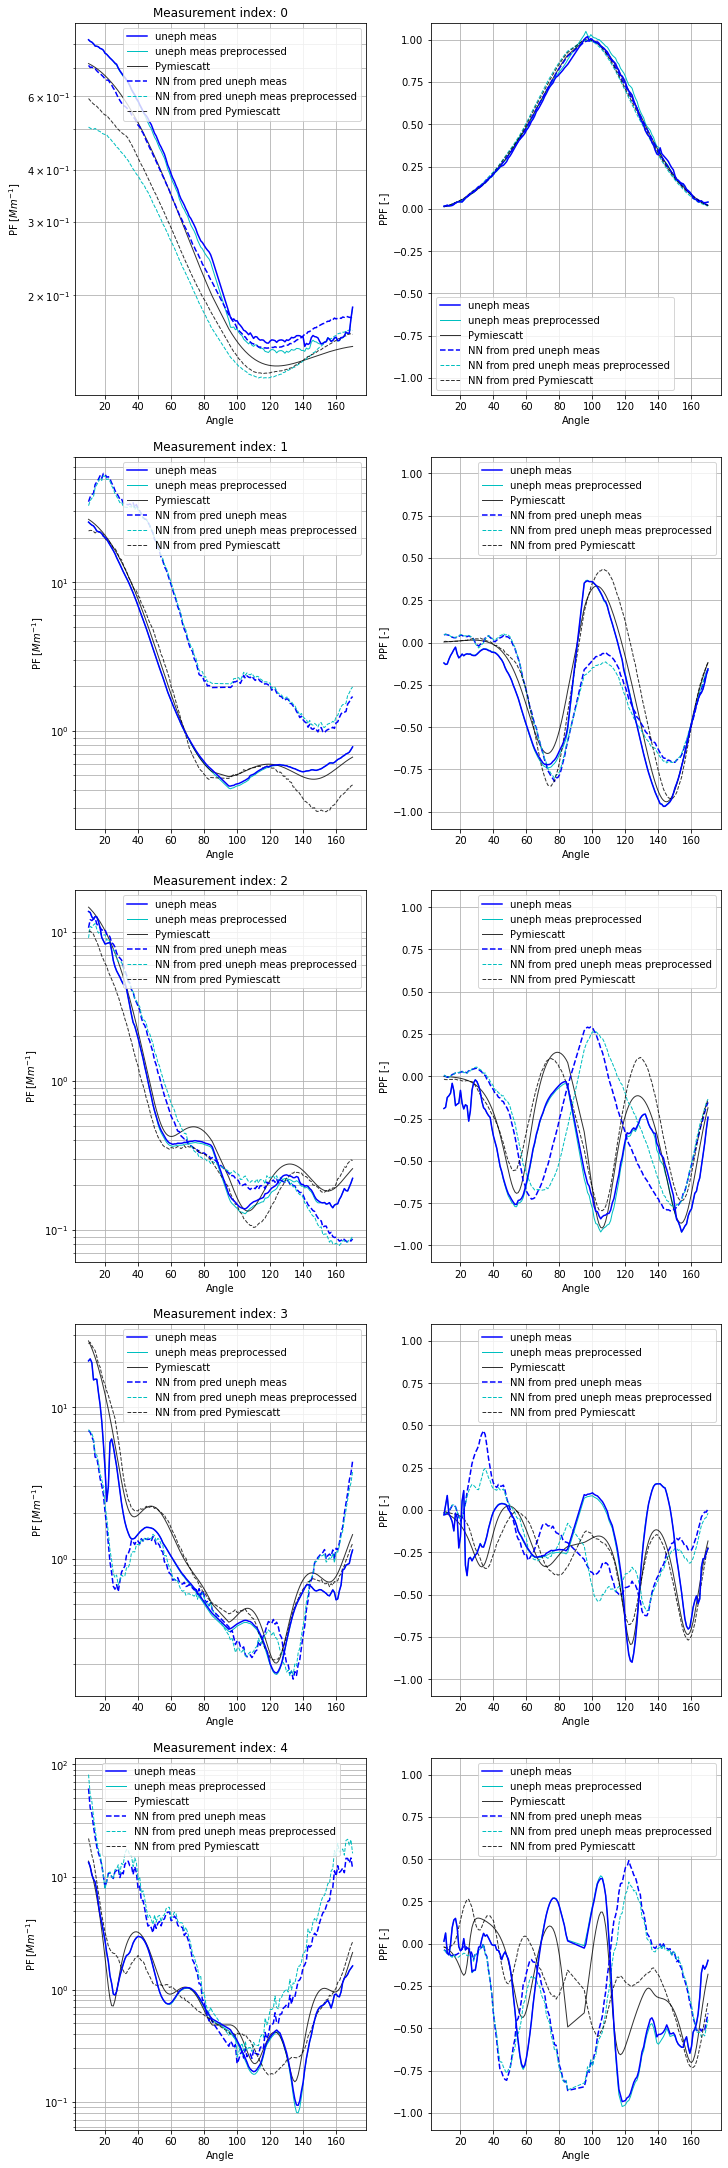

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 30), constrained_layout=True)
for index in range(5):
    axs[index,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')
    meas_pred_plot, = axs[index,1].plot(angles, (qoi_meas_pred[PPF_list].loc[index]), ls = '--',c='b',  label='NN from pred uneph meas')

    meas_prepro_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    meas_prepro_pred_plot, = axs[index,1].plot(angles, qoi_meas_preprocessed_pred[PPF_list].loc[index], ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')
    pms_pred_plot, = axs[index,1].plot(angles, qoi_meas_pymiescatt_pred[PPF_list].loc[index], ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt') 

        
    meas_plot, = axs[index,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

        
        

        
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred0_4.jpg')


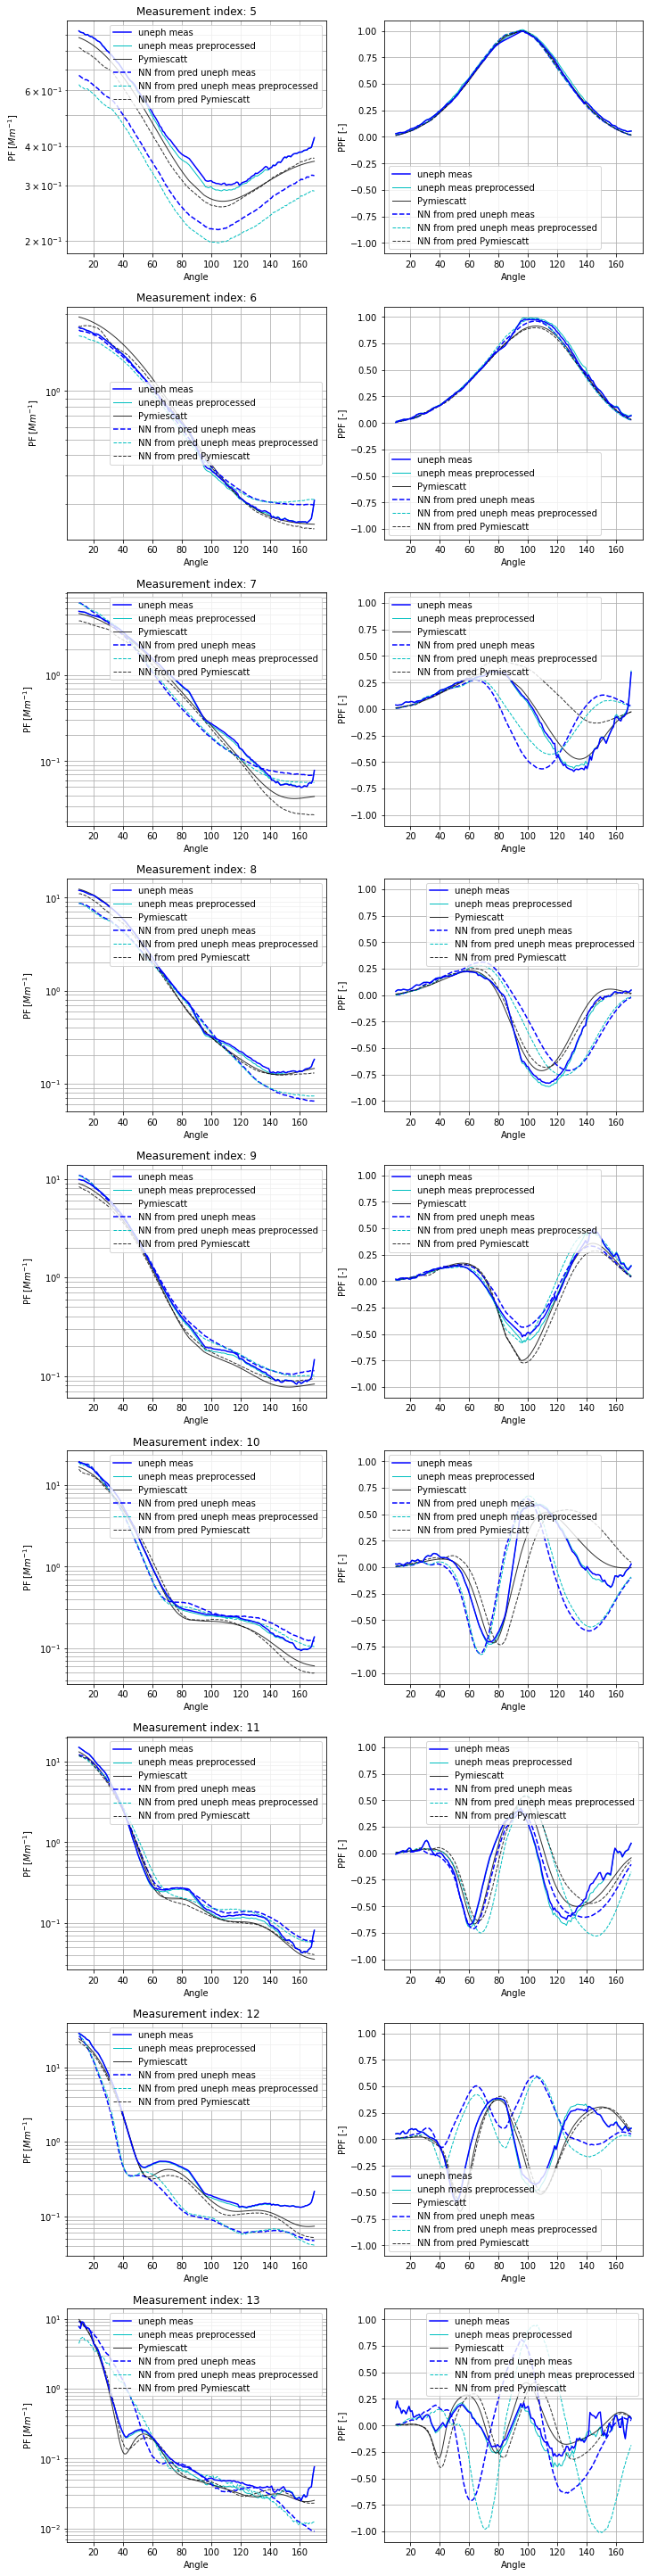

In [29]:

fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(10, 40), constrained_layout=True)
for index in range(5,14):
    axs[index-5,0].set_title('Measurement index: '+str(index))


    meas_prepro_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed[F11_columns_meas].loc[index]), lw='1',c= 'c', label = 'uneph meas preprocessed')
    meas_prepro_plot, = axs[index-5,1].plot(angles, qoi_meas_preprocessed[PPF_columns_meas].loc[index], lw='1',c= 'c', label = 'uneph meas preprocessed')
    
    pms_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt[F11_list].loc[index]), lw='1', c='k', alpha=0.8, label='Pymiescatt')
    pms_plot, = axs[index-5,1].plot(angles, qoi_meas_pymiescatt[PPF_list].loc[index], lw='1', c='k', alpha=0.8, label='Pymiescatt')
     
    meas_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pred[F11_list].loc[index]), ls = '--', c='b',  label='NN from pred unpeh meas')
    meas_pred_plot, = axs[index-5,1].plot(angles, (qoi_meas_pred[PPF_list].loc[index]), ls = '--',c='b',  label='NN from pred uneph meas')

    meas_prepro_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_preprocessed_pred[F11_list].loc[index]), ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    meas_prepro_pred_plot, = axs[index-5,1].plot(angles, qoi_meas_preprocessed_pred[PPF_list].loc[index], ls = '--',lw='1',c= 'c', label = 'NN from pred uneph meas preprocessed')
    
    pms_pred_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas_pymiescatt_pred[F11_list].loc[index]), ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt')
    pms_pred_plot, = axs[index-5,1].plot(angles, qoi_meas_pymiescatt_pred[PPF_list].loc[index], ls = '--',lw='1', c='k', alpha=0.8, label='NN from pred Pymiescatt') 

        
    meas_plot, = axs[index-5,0].plot(angles, np.exp(qoi_meas[F11_columns_meas].loc[index]), c='b',  label='unpeh meas')
    meas_plot, = axs[index-5,1].plot(angles, (qoi_meas[PPF_columns_meas].loc[index]),  c='b',  label='uneph meas')

        
        

        
    axs[index-5,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index-5,1].set_ylabel('PPF [-]')
    axs[index-5,1].set_ylim(-1.1, 1.1)
    axs[index-5,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[meas_plot,meas_prepro_plot, pms_plot,meas_pred_plot,meas_prepro_pred_plot, pms_pred_plot])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/measurements_pred5_13.jpg')


# Make predictions with Pymiescatt

In [30]:
D_array = np.logspace(0.1, 5, 300)

In [31]:
angles_new = np.arange(10,171)
len(angles_new)

161

In [32]:
qoi_list_pms_F11 = []
qoi_list_pms_PPF = []
qoi_list_pms = []
for i in range(10,171):
    qoi_list_pms.append('F11_'+str(i))
    qoi_list_pms_F11.append('F11_'+str(i))
for i in range(10,171):
    qoi_list_pms.append('PPF_'+str(i))
    qoi_list_pms_PPF.append('PPF_'+str(i))


In [ ]:
# qoi with Pymiescatt: prediction of measurement data
pms_qoi_meas_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pred.csv') 

In [33]:
pms_qoi_meas_pred = pd.read_csv(f'{plot_dir}/pms_qoi_meas_pred.csv')

In [ ]:
# qoi with Pymiescatt: prediction of processed measurement data
pms_qoi_meas_preprocessed_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_preprocessed_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_preprocessed_pred.to_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv') 

In [34]:
pms_qoi_meas_preprocessed_pred = pd.read_csv(f'{plot_dir}/pms_qoi_meas_preprocessed_pred.csv')

In [ ]:
# qoi with Pymiescatt: prediction of with pymiescatt predicted measurement data
pms_qoi_meas_pymiescatt_pred = pd.DataFrame(columns = qoi_list_pms)

for index in range(14):
    param_tmp = dvar_meas_pymiescatt_pred.iloc[index]
    DmedianV_tmp = param_tmp['RmedianV']*2  # [um]
    GSD_tmp = param_tmp['GSD']
    Vtot_tmp = param_tmp['Vtot']
    n_tmp = param_tmp['n']
    k_tmp = param_tmp['k']
    DmedianN_tmp = (np.exp(np.log(DmedianV_tmp) - (3*np.log(GSD_tmp)**2))) *1e3   # [nm]
    Ntot_tmp = 6 / np.pi * Vtot_tmp*1e9 / (np.exp((3*np.log(DmedianN_tmp)) + (4.5*np.log(GSD_tmp)**2))) # [cm^-3]
    print(DmedianN_tmp)
    print(Ntot_tmp)
    F11, F12, PPF = run_pymiescatt(DmedianN_tmp/2*1e-3, GSD_tmp, Ntot_tmp, n_tmp, k_tmp, 0.532, angles_new, D_array)
    pms_qoi_meas_pred.loc[index]=np.concatenate([F11,PPF])
pms_qoi_meas_pymiescatt_pred.to_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv') 

In [35]:
pms_qoi_meas_pymiescatt_pred= pd.read_csv(f'{plot_dir}/pms_qoi_meas_pymiescatt_pred.csv')

In [36]:
# Calculate relative error for aerosol retrieval

In [37]:
def rel_error(true, pred):
    relative_error = np.abs(true-pred)/np.abs(true)*100
    return relative_error

In [38]:
relerr1 = rel_error(dvar_meas, dvar_meas_pred)
print(relerr1.mean())
relerr2 = rel_error(dvar_meas, dvar_meas_preprocessed_pred)
print(relerr2.mean())
relerr3 = rel_error(dvar_meas, dvar_meas_pymiescatt_pred)
print(relerr3.mean())

Vtot           45.831258
RmedianV       24.185881
GSD             4.325030
n               4.640743
k           10520.401931
dtype: float64
Vtot          48.904044
RmedianV      23.997461
GSD            4.293934
n              4.502247
k           5123.296773
dtype: float64
Vtot           5.986022
RmedianV       4.362707
GSD            0.902127
n              0.785443
k           5836.310816
dtype: float64


In [39]:
# Calculate relative error for forward simulation

In [40]:
qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')

<ipython-input-40-867fea1fd93e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  qoi_meas.columns = qoi_meas.columns.str.replace('_0.532_','_')


In [41]:
qoi_meas[F11_list] = np.exp(qoi_meas[F11_list])
qoi_pred[F11_list] = np.exp(qoi_pred[F11_list])
qoi_meas_pred[F11_list] = np.exp(qoi_meas_pred[F11_list])
qoi_meas_preprocessed_pred[F11_list] = np.exp(qoi_meas_preprocessed_pred[F11_list])
qoi_meas_pymiescatt_pred[F11_list] = np.exp(qoi_meas_pymiescatt_pred[F11_list])

In [42]:
relerr4 = rel_error(qoi_meas, qoi_pred)
relerr5 = rel_error(qoi_meas, qoi_meas_pred)
relerr6 = rel_error(qoi_meas, qoi_meas_preprocessed_pred)
relerr7 = rel_error(qoi_meas, qoi_meas_pymiescatt_pred)


In [43]:
rel_error_df_iv0_4 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv0_4.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[0:4].mean(), relerr1['RmedianV'].loc[0:4].mean(), relerr1['GSD'].loc[0:4].mean(), relerr1['n'].loc[0:4].mean(), relerr1['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[0:4].mean(), relerr2['RmedianV'].loc[0:4].mean(), relerr2['GSD'].loc[0:4].mean(), relerr2['n'].loc[0:4].mean(), relerr2['k'].loc[0:4].mean()]
rel_error_df_iv0_4.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[0:4].mean(), relerr3['RmedianV'].loc[0:4].mean(), relerr3['GSD'].loc[0:4].mean(), relerr3['n'].loc[0:4].mean(), relerr3['k'].loc[0:4].mean()]
rel_error_df_iv0_4 = np.round(rel_error_df_iv0_4, decimals = 2)
rel_error_df_iv0_4

Vtot  RmedianV   GSD     n         k
meas_vs_pred               106.24     48.89  7.75  4.58  29379.10
meas_vs_preprocessed_pred  105.48     49.20  7.17  4.05  14255.60
meas_vs_pymiescatt_pred      8.35      8.36  1.54  0.74  16320.55

In [44]:
rel_error_df_iv5_13 = pd.DataFrame(columns = [ 'Vtot','RmedianV','GSD','n','k'])
rel_error_df_iv5_13.loc['meas_vs_pred'] = [relerr1['Vtot'].loc[5:13].mean(), relerr1['RmedianV'].loc[5:13].mean(), relerr1['GSD'].loc[5:13].mean(), relerr1['n'].loc[5:13].mean(), relerr1['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_preprocessed_pred'] = [relerr2['Vtot'].loc[5:13].mean(), relerr2['RmedianV'].loc[5:13].mean(), relerr2['GSD'].loc[5:13].mean(), relerr2['n'].loc[5:13].loc[5:13].mean(), relerr2['k'].loc[5:13].mean()]
rel_error_df_iv5_13.loc['meas_vs_pymiescatt_pred'] = [relerr3['Vtot'].loc[5:13].mean(), relerr3['RmedianV'].loc[5:13].mean(), relerr3['GSD'].loc[5:13].mean(), relerr3['n'].loc[5:13].mean(), relerr3['k'].loc[5:13].mean()]
rel_error_df_iv5_13 = np.round(rel_error_df_iv5_13, decimals = 2)
rel_error_df_iv5_13

Vtot  RmedianV   GSD     n      k
meas_vs_pred               12.27     10.46  2.42  4.67  43.35
meas_vs_preprocessed_pred  17.47     10.00  2.69  4.76  49.80
meas_vs_pymiescatt_pred     4.68      2.14  0.55  0.81  11.73

In [45]:
rel_error_df_fw0_4 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw0_4.loc['meas_vs_pred'] = [relerr4[F11_list].loc[0:4].mean().mean(),relerr4[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[0:4].mean().mean(),relerr5[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[0:4].mean().mean(),relerr6[PPF_list].loc[0:4].mean().mean()]
rel_error_df_fw0_4.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[0:4].mean().mean(),relerr7[PPF_list].loc[0:4].mean().mean()]

rel_error_df_fw0_4 = np.round(rel_error_df_fw0_4, decimals = 2)
rel_error_df_fw0_4

F11     PPF
meas_vs_pred                     26.81  220.56
meas_vs_meas_pred               140.78  307.83
meas_vs_meas_preprocessed_pred  171.20  320.82
meas_vs_meas_pymiescatt_pred     26.80  179.42

In [46]:
rel_error_df_fw5_13 = pd.DataFrame(columns = ['F11','PPF'])
rel_error_df_fw5_13.loc['meas_vs_pred'] = [relerr4[F11_list].loc[5:13].mean().mean(),relerr4[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pred'] = [relerr5[F11_list].loc[5:13].mean().mean(),relerr5[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13.loc['meas_vs_meas_preprocessed_pred'] = [relerr6[F11_list].loc[5:13].mean().mean(),relerr6[PPF_list].loc[5:13].mean().mean()]
rel_error_df_fw5_13.loc['meas_vs_meas_pymiescatt_pred'] = [relerr7[F11_list].loc[5:13].mean().mean(),relerr7[PPF_list].loc[5:13].mean().mean()]

rel_error_df_fw5_13 = np.round(rel_error_df_fw5_13, decimals = 2)
rel_error_df_fw5_13

F11      PPF
meas_vs_pred                    13.06   837.03
meas_vs_meas_pred               27.43  1091.20
meas_vs_meas_preprocessed_pred  26.60  2264.11
meas_vs_meas_pymiescatt_pred    17.14  1051.00

In [47]:
rel_error_df_iv0_4.to_csv(f'{plot_dir}/rel_error_df_iv0_4.csv')
rel_error_df_iv5_13.to_csv(f'{plot_dir}/rel_error_df_iv5_13.csv')
rel_error_df_fw0_4.to_csv(f'{plot_dir}/rel_error_df_fw0_4.csv')
rel_error_df_fw5_13.to_csv(f'{plot_dir}/rel_error_df_fw5_13.csv')

In [48]:
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1_small/plots_meas_original'